Load in dependencies and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import Counter
from scipy.optimize import curve_fit
from scipy.stats import poisson
import seaborn as sb
import matplotlib.cm as cm
import networkx as nx

In [20]:
# Load data
with open('D:\Good_Lab_Data\GerminalCenters/tonsil_vdjs_annotated.tsv', 'r') as file:
    df = pd.read_csv(file, sep=',', dtype=str)

# Focus on heavy chains within follicles

filtered_df = df[(df['follicle'] != 'EF') & (df['locus'] == 'IGH')]
df_filt = filtered_df[['vdj_sequence', 'lineage_id', 'follicle']].copy()
df_filt['lineage_id'] = df_filt['lineage_id'].astype(float).round().astype(int)

column_positions = {}
for column in df_filt.columns:
    unique_elements = sorted(df_filt[column].unique())
    column_positions[column] = {element: idx for idx, element in enumerate(unique_elements)}

# Number of UMIs in each lineage in each follicle
lineage_foll = np.zeros((len(column_positions['lineage_id']),len(column_positions['follicle'])))
for _, row in df_filt.iterrows():
    lineage_idx = column_positions['lineage_id'][row['lineage_id']]
    follicle_idx = column_positions['follicle'][row['follicle']]
    lineage_foll[lineage_idx, follicle_idx] += 1
lineage_foll = lineage_foll.astype(int)

# Number of UMIs of each clone in each follicle
clone_foll = np.zeros((len(column_positions['vdj_sequence']),len(column_positions['follicle'])))
for _, row in df_filt.iterrows():
    clone_idx = column_positions['vdj_sequence'][row['vdj_sequence']]
    follicle_idx = column_positions['follicle'][row['follicle']]
    clone_foll[clone_idx, follicle_idx] += 1
clone_foll = clone_foll.astype(int)

# Shuffled matrix
lin_foll_unstack = np.zeros((np.sum(lineage_foll), 3))
k = 0
for i in range(0,lineage_foll.shape[0]):
    for j in range(0,lineage_foll.shape[1]):
        lin_foll_unstack[k:k+lineage_foll[i,j],0] = i
        lin_foll_unstack[k:k+lineage_foll[i,j],1] = j
        lin_foll_unstack[k:k+lineage_foll[i,j],2] = j
        k += lineage_foll[i, j]
np.random.shuffle(lin_foll_unstack[:, 2])
lin_foll_shuffled = np.zeros((lineage_foll.shape[0],lineage_foll.shape[1]))
for i in range(0,lin_foll_unstack.shape[0]):
    lin_foll_shuffled[int(lin_foll_unstack[i,0]),int(lin_foll_unstack[i,2])] += 1

# Follicle positions
foll_pos = np.loadtxt("D:/Good_Lab_Data/GerminalCenters/follicle_centroids.txt", usecols=(2, 3), skiprows=1)/60 # Convert to mm

Helper functions

In [3]:
# Function to count number of UMIs conditioned on number of follicles
def N_given_n(cfam, edges, n, n_upper = 0):
    if n_upper == 0:
        nlets = np.sum(cfam > 0, axis = 1) == n
    else:
        nlets = np.logical_and(np.sum(cfam > 0, axis = 1) >= n, np.sum(cfam > 0, axis = 1) <= n_upper)
    N = np.sum(cfam, axis = 1)

    hist_vals = np.histogram(N[nlets], bins = edges)[0]

    density_vals = (hist_vals / (edges[1:]-edges[:-1]) ) / np.sum(hist_vals)
    density_err = (np.sqrt(hist_vals) / (edges[1:]-edges[:-1]) ) / np.sum(hist_vals)

    x_vals = np.zeros(len(hist_vals))

    for i in range(0,len(edges)-1):
        N_slice = N[np.logical_and(np.logical_and(nlets, N >= edges[i]), N < edges[i+1])]

        if len(N_slice) == 0:
            x_vals[i] = (edges[i] + edges[i+1]) / 2
        else:
            x_vals[i] = np.median(N_slice)

    return x_vals, density_vals, density_err

# Power law for fitting
def power_law(n, a):
    given_one =  -a * np.log(n[:9]) - np.log(np.sum(n[:9]**-a))
    given_two =  -a * np.log(n[9:17]) - np.log(np.sum(n[9:17]**-a))
    given_three =  -a * np.log(n[17:]) - np.log(np.sum(n[17:]**-a))
    return np.hstack((given_one, given_two, given_three))

# Error bars for log log plots
def log_error_bar(y, y_err):
    return [y*(1- np.exp(-y_err/y)), y*(np.exp(y_err/y) -1)]

Power law distribution of UMI number per clonal family

C:\Users\johnd\AppData\Local\Temp\ipykernel_47560\2682206534.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', 3)


(0.9, 10.04510856630514)

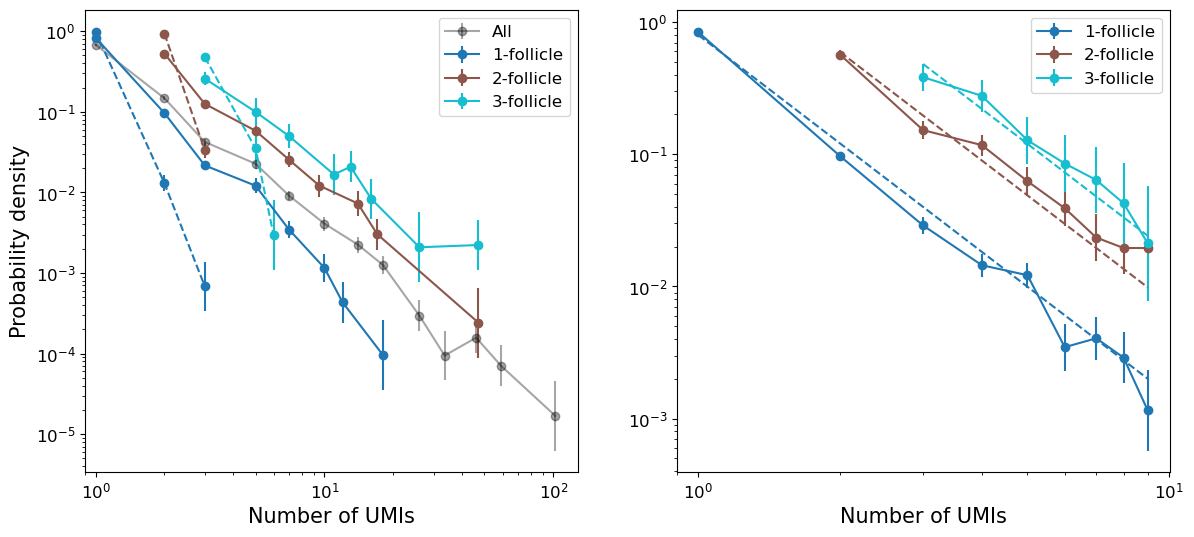

In [37]:
N = np.sum(lineage_foll, axis=1)
N_foll = np.sum(lineage_foll > 0, axis=1)

n_bins = 15
bin_edges = np.exp(np.linspace(0, np.max(np.log(N)), n_bins + 1))
bin_edges = np.unique(np.round(np.insert(bin_edges, 1, 2)))
bin_edges[-1] += 1

colors = cm.get_cmap('tab10', 3)

N_vals, density, density_err = N_given_n(lineage_foll, bin_edges, 1, bin_edges[-1])

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Comparison to shuffled data
axs[0].errorbar(N_vals[density > 0], density[density > 0], yerr=log_error_bar(density[density > 0], density_err[density > 0]), marker='o', linestyle='-', label='All', color=(0,0,0,0.35))

for n in range(1, 4):
    N_vals, density, density_err = N_given_n(lineage_foll, bin_edges, n)
    axs[0].errorbar(N_vals[density > 0], density[density > 0], yerr=log_error_bar(density[density > 0], density_err[density > 0]), marker='o', linestyle='-', label=f'{n}-follicle', color=colors(n-1))

    N_vals, density, density_err = N_given_n(lin_foll_shuffled, bin_edges, n)
    axs[0].errorbar(N_vals[density > 0], density[density > 0], yerr=log_error_bar(density[density > 0], density_err[density > 0]), marker='o', linestyle='--', color=colors(n-1))

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('Number of UMIs', fontsize=15)
axs[0].set_ylabel('Probability density', fontsize=15)
axs[0].legend(fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].set_xlim(left=0.9)

# Comparison to power law

lineage_foll_filtered = lineage_foll[np.logical_and(N <= 9, N_foll <= 3),:]

N = np.sum(lineage_foll_filtered, axis=1)
N_foll = np.sum(lineage_foll_filtered > 0, axis=1)
N1 = np.sum(lineage_foll_filtered[N_foll == 1], axis=1)
N2 = np.sum(lineage_foll_filtered[N_foll == 2], axis=1)
N3 = np.sum(lineage_foll_filtered[N_foll == 3], axis=1)

density_all = np.histogram(N, bins = range(1,11))[0]
density_1 = np.histogram(N1, bins = range(1,11))[0]
density_2 = np.histogram(N2, bins = range(1,11))[0]
density_3 = np.histogram(N3, bins = range(1,11))[0]

d_err_all = np.sqrt(density_all) / np.sum(density_all)
density_all = density_all / np.sum(density_all)

d_err_1 = np.sqrt(density_1) / np.sum(density_1)
density_1 = density_1 / np.sum(density_1)

d_err_2 = np.sqrt(density_2) / np.sum(density_2)
density_2 = density_2 / np.sum(density_2)

d_err_3 = np.sqrt(density_3) / np.sum(density_3)
density_3 = density_3 / np.sum(density_3)

N_vals = np.array(range(1,10))

axs[1].errorbar(N_vals[density_1 > 0], density_1[density_1 > 0], yerr = log_error_bar(density_1[density_1 > 0], d_err_1[density_1 > 0]), marker='o', linestyle='-', label='1-follicle',color=colors(0))
axs[1].errorbar(N_vals[density_2 > 0], density_2[density_2 > 0], yerr = log_error_bar(density_2[density_2 > 0], d_err_2[density_2 > 0]), marker='o', linestyle='-', label='2-follicle',color=colors(1))
axs[1].errorbar(N_vals[density_3 > 0], density_3[density_3 > 0], yerr = log_error_bar(density_3[density_3 > 0], d_err_3[density_3 > 0]), marker='o', linestyle='-', label='3-follicle',color=colors(2))

popt, pcov = curve_fit(power_law, np.concatenate((N_vals, N_vals[N_vals > 1], N_vals[N_vals > 2])), np.log(np.hstack((density_1, density_2[N_vals > 1], density_3[N_vals > 2]))))
y_vals = np.exp(power_law(np.concatenate((N_vals, N_vals[N_vals > 1], N_vals[N_vals > 2])), *popt))

axs[1].plot(N_vals, y_vals[:9],'--', color=colors(0))
axs[1].plot(N_vals[N_vals > 1], y_vals[9:17],'--', color=colors(1))
axs[1].plot(N_vals[N_vals > 2], y_vals[17:], '--', color=colors(2))

axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_xlabel('Number of UMIs', fontsize=15)
axs[1].legend(fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].set_xlim(left=0.9)


Left: Probability distribution of number of UMIs observed for each clonal family, conditioned on the number of follicles the clonal family is observed in. Dashed lines show the corresponding distributions for "well-mixed" data, where the follicle labels each UMI is observed in is shuffled. The grey line shows the distribution of all UMIs, which is the same for shuffled and unshuffled data.

Right: Similar conditional probability distribution of number of UMIs observed for each clonal family, filtered to exclude clonal families with 10 or more UMIs. The dashed lines show the same best-fit power law distribution for all three curves, accounting for the fact that observing a clonal family in n follicles necessitates observing at least n UMIs. The power law coefficient is approximately 2.7.

All error bars show counting error adjusted for log space.

Number of follicles conditioned on number of UMIs

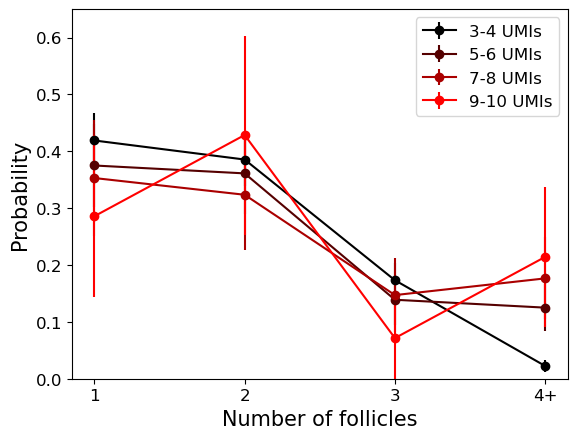

In [8]:
N = np.sum(lineage_foll, axis=1)
N_foll = np.sum(lineage_foll > 0, axis=1)

lin_foll_filtered = lineage_foll[N <= 10,:]

N_folls = []
N = np.sum(lin_foll_filtered, axis=1)

for i in range(3,7):
    N_folls.append(np.sum(lin_foll_filtered[np.logical_or(N == 2*i-3, N == 2*i-3+1),:] > 0, axis = 1))
    density = np.array([np.sum(N_folls[-1] == 1), np.sum(N_folls[-1] == 2), np.sum(N_folls[-1] == 3), np.sum(N_folls[-1] > 3)])
    d_err = np.sqrt(density) / len(N_folls[-1])
    density = density / len(N_folls[-1])
    plt.errorbar(range(1,5), density, yerr = d_err, marker='o', linestyle='-', label=f'{2*i-3}-{2*i-3+1} UMIs', color=((i-3)/3, 0, 0))

plt.ylim([0, 0.65])
plt.xticks([1, 2, 3, 4], ['1', '2', '3', '4+'], fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Probability',fontsize=15)
plt.xlabel('Number of follicles',fontsize=15)
plt.legend(fontsize=12)

Probability of a clonal family being localized to a certain number of follicles, conditioned on the number of observed UMIs. Error bars show counting error.

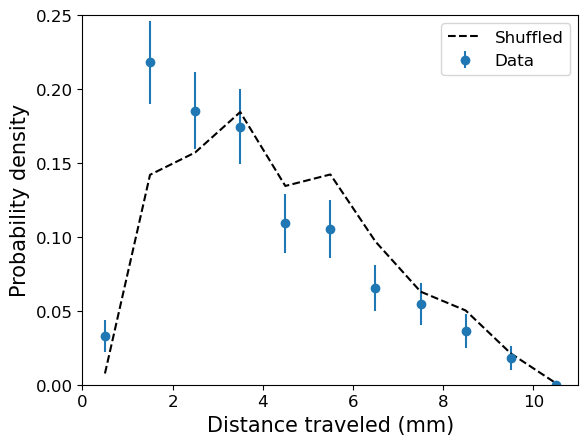

In [19]:
N_foll = np.sum(lineage_foll > 0, axis=1)
N = np.sum(lineage_foll, axis=1)

edges = np.linspace(0,11,12)

k = 2
lin_foll_filtered = lineage_foll[N_foll == 2,:]
dist_traveled = np.zeros(lin_foll_filtered.shape[0])

for i in range(0,len(dist_traveled)):
    nonzero_indices = np.nonzero(lin_foll_filtered[i, :])[0]
    max_dist = 0
    dist_traveled[i] = np.sqrt(np.sum((foll_pos[nonzero_indices[0],:] - foll_pos[nonzero_indices[1],:])**2))

dists2 = np.histogram(dist_traveled, bins = edges)[0]


# Histogram if independent
N_in_foll = np.sum(lin_foll_filtered > 0, axis=0)
foll_dists = np.zeros(len(N_in_foll)*(len(N_in_foll)-1)//2)
weights = np.zeros(len(N_in_foll)*(len(N_in_foll)-1)//2)
k = 0
for i in range(0, len(N_in_foll)):
    for j in range(i+1, len(N_in_foll)):
        weights[k] = N_in_foll[i]*N_in_foll[j]
        foll_dists[k] = np.sqrt(np.sum((foll_pos[i,:] - foll_pos[j,:])**2))
        k += 1

shuffled_dists = np.histogram(foll_dists, bins=edges, weights = weights)[0]

plt.errorbar((edges[:-1]+edges[1:])/2, dists2/np.sum(dists2), np.sqrt(dists2)/np.sum(dists2), fmt='o',label='Data')
plt.plot((edges[:-1]+edges[1:])/2, shuffled_dists/np.sum(shuffled_dists), 'k--',label = 'Shuffled')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0, 0.25])
plt.xlabel('Distance traveled (mm)', fontsize = 15)
plt.ylabel('Probability density',fontsize=15)
plt.legend(fontsize = 12)

plt.show()




For each lineage found in exactly two follicles, probability distribution of the 2-dimensional Euclidean distance between those follicles (defined by their centroids). Black dashed line shows the corresponding distribution if follicle membership was chosen independent of distance, weighted only by the number of lineages each follicle contains.

9.352893168823543


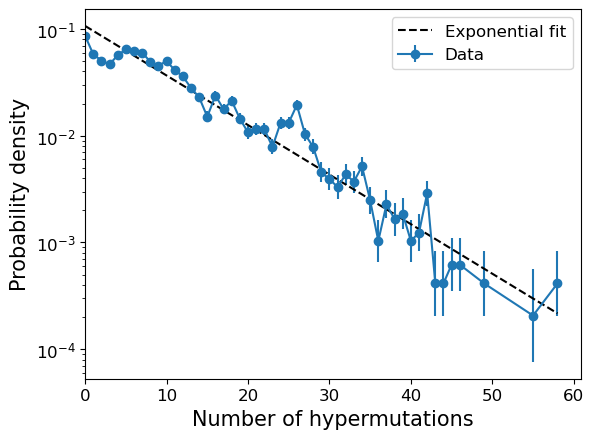

In [50]:
def log_exp_fit(x, a):
    return -a * x + np.log(a)

# Distribution of putative hypermutation counts

n_mismatches = np.array(filtered_df['v_mismatch']).astype(int)

vals = np.histogram(n_mismatches,bins=np.arange(60)-0.5)[0]

x = np.arange(59)[vals > 0]
y = np.log(vals[vals > 0]/np.sum(vals))

popt, pcov = curve_fit(log_exp_fit, x, y)
a = popt[0]
print(1/a)

plt.errorbar(np.arange(59)[vals > 0], vals[vals > 0]/np.sum(vals), yerr = log_error_bar(vals[vals > 0]/np.sum(vals), np.sqrt(vals[vals > 0])/np.sum(vals)), marker='o', linestyle='-',label='Data')

plt.plot(x, np.exp(log_exp_fit(x, a)), label='Exponential fit', color='black',linestyle='--')

plt.yscale('log')
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Number of hypermutations',fontsize=15)
plt.ylabel('Probability density',fontsize = 15)

plt.xlim(left=0)
plt.show()

Distribution of number of hypermutations for intrafollicular heavy chain reads. Dashed line shows an exponential fit, where the mean number of hypermutations is approximately 9.4.